In [28]:
# Make autoload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
from ase import Atoms
from agox.environments import Environment
from agox.utils.plot import plot_atoms, plot_cell
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
from tqdm import tqdm
# environment
from rlweek.atomic_environment import (
    AtomisticEnvironment,
    get_agox_environment,
    get_lennard_jones_calculator,
)
import torch

# An environment for atomistic optimization. 

This notebook will not so much be a tutorial, but a presentation of an idea that can be 
worked further on. 

We have seen that algorithms can be formulated that can solve multiple environments, 
we have played around with neural networks as the parameterization of these agents. 
Now the goal is to formulate an environment that describes an atomistic optimization 
problem and hopefully try some algorithms on the problem. 

The general outline of this environment is as follows, the initial state of the environment 
is an atomic system with a number of atoms already placed at random in the computational cell, 
in the code I have implemented below this is a `Graph`-space with node attributes 
describing the positions and types of atom. 
An action is an index of an atom and a new position for that atom. That is

$ a = (i, x, y, z) $

This I have created as a `Tuple`-space with a `Discrete`-space for the index and 
a `Box`-space for the positions. 

An episode runs for a prespecified number of steps, this could later be changed 
to letting the agent terminate the episode. There are at least two related choices 
for the reward, lets define: 

$ E_0 = \mathrm{Energy \ of \ the \ initial \ state} $

And so $E_1$ is the energy of the following state and $E_T$ is the energy of final state. 
One possibility for the reward is thus: 

$
\begin{align}
r_t &= 0 \ \mathrm{if} \ s_t \neq s_T \\
r_t &= E_0 - E_T  \ \mathrm{if} \ s_t = s_T
\end{align}
$

That is, each step is given a reward of 0 but final state is given the negative difference 
between energy of the initial and the final state, which if the structure improves is a positive quantity. Another option is

$
\begin{equation}
r_t = -\Delta E_t = E_{t-1}-E_{t} 
\end{equation}
$

I am not sure what is the better choice, or if another choice is better. The 
discounted returns that these describe are

$
\begin{align}
G_t &= \sum_{k=t}^T \gamma^{k-t} r_t \\
& = \gamma^{T-t} (E_0 - E_T)
\end{align}
$

and 

$
\begin{align}
G_t &= \sum_{k=t}^T \gamma^{k-t} r_t \\
& = \sum_{k=t}^T \gamma^{k-t} (E_{t-1} - E_{t}) 
\end{align}
$

If $\gamma = 1$ then these will be the same (for $t=0$), as in the second expression all terms except $E_0$ and $E_T$ will cancel. 
But in the discounted case, the is a difference in how they work, e.g in the first one the last action 
is responbile for the full reward even if $E_{T} - E_{T-1}$ is very small, whereas in the second option 
actions are not 'responsible' for the rewards of previous steps - which seems like a better idea?
If you are worried by the number of energy calculations required for these reward functions 
then worry not, remember the magic of *machine learning potentials* (or in this case cheap potentials) .
I have implemented the second option, but if you feel like the first is preferable please try that!

Remember that the value function is the expectation value of the (discounted) return while following the policy. 
This means that with our above reward functions the value function will essentially learn how much a 
the energy of a configuration of atoms can improve, so the value of the optimum is zero whereas the value 
of a poor structure is high. The action-values learn the expectation value of the (discounted) return 
after taking a specific action, so it will represent the improvement possible after taking a 
specific action. 

A normalization of the reward could also be done, e.g. by tracking the best energy found thus far - 
though I dont know what the effect of that is on the mathematical foundations. 

In [30]:
from rlweek.atomic_environment import AtomisticEnvironment, get_agox_environment, get_lennard_jones_calculator, graph_to_atoms

The environment can be setup like this

In [31]:
calc = get_lennard_jones_calculator() # This can be changed to any ASE calculator. 
agox_env = get_agox_environment('H5') # This can be changed to any AGOX environment. 
env = AtomisticEnvironment(agox_env, calc=calc, n_steps=9)

We can run an episode with just random actions drawn uniformly from the action space:

In [32]:
terminal = False
state, _ = env.reset()

trajectory = [env.atoms.copy()]
states = [state]
rewards = [0]
actions = [()]
while not terminal:
    action = env.action_space.sample()
    state, reward, terminal, _, _ = env.step(action)

    states.append(state)
    rewards.append(reward)
    actions.append(action)
    trajectory.append(env.atoms.copy())

G = np.sum(rewards)
print(f'Return: {G}')

Return: -0.15056133270263672


Then we can plot each step of the episode, like so: 

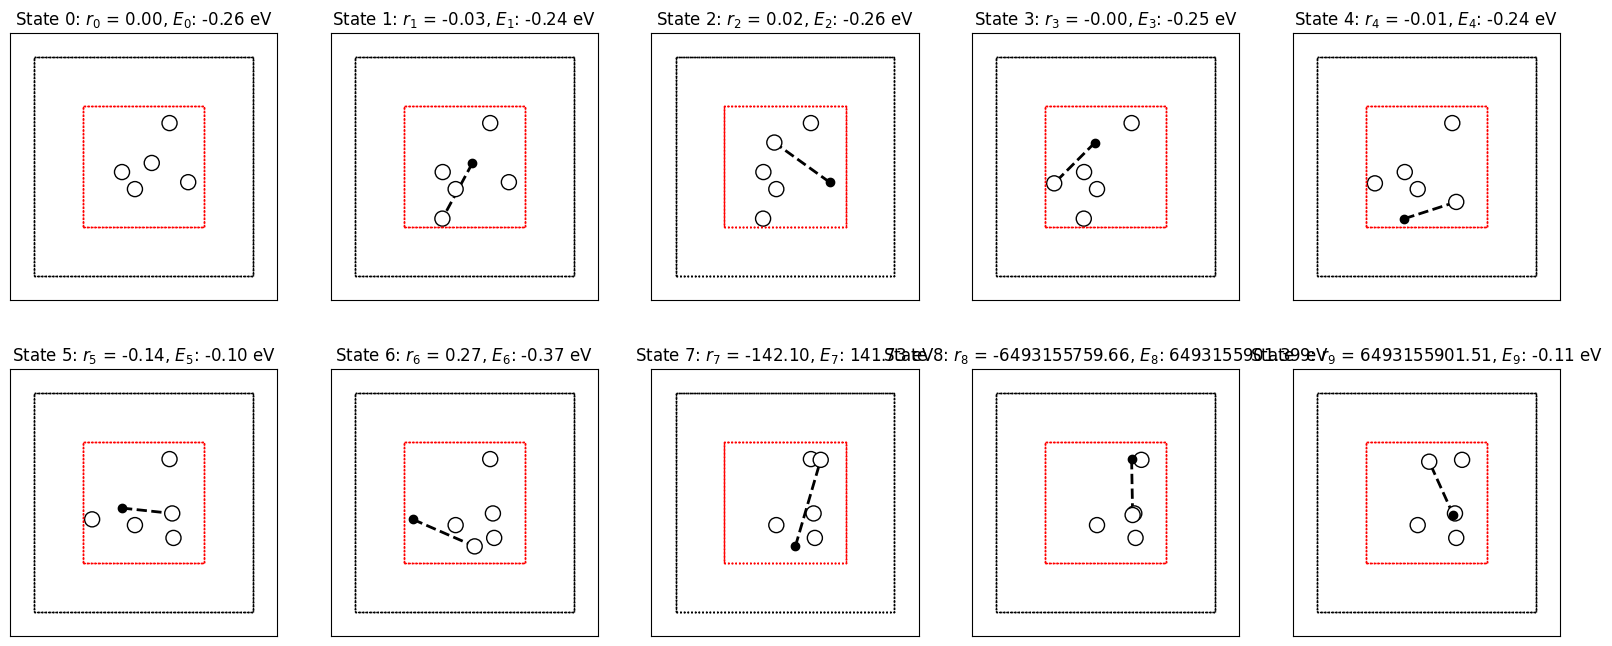

In [33]:
sz = 4
fig, ax = plt.subplots(2, 5, figsize=(sz*5, sz*2))

data = [graph_to_atoms(state, agox_env) for state in states]

energies = [env.get_energy(atoms) for atoms in data]

cell = data[0].get_cell()

confinement_cell = agox_env.confinement_cell
confinement_corner = agox_env.confinement_corner

for i, (atoms, r, ax) in enumerate(zip(data, rewards, ax.flatten())):
    plot_atoms(ax=ax, atoms=atoms)

    ax.set_xlim([-1, cell[0, 0]+1])
    ax.set_ylim([-1, cell[1, 1]+1])

    plot_cell(ax, cell, plane='xy', collection_kwargs={'edgecolor':'black', 'zorder':2})
    plot_cell(ax, confinement_cell, plane='xy', offset=confinement_corner, collection_kwargs={'edgecolor':'red'})

    if i > 0:
        index = actions[i][0]
        p0 = data[i-1].positions[index] 
        p1 = data[i].positions[index]

        ax.plot(p0[0], p0[1], 'ko', zorder=1)
        ax.plot([p0[0], p1[0]], [p0[1], p1[1]], 'k--', lw=2, zorder=0)


    ax.set_title(f'State {i}: $r_{i}$ = {r:.2f}, $E_{i}$: {env.get_energy(atoms):.2f} eV')

Obviously moving things at random, without even taking common bond lengths into account is not often going to lead to an improvement, but it does give us a baseline of 
performance. 

I have created three simple agents: 
- A `RandomAgent` that simply samples actions uniformly from the environments action space. 
- A `RattleAgent` that uses AGOX's RattleGenerator to move atoms around, this takes bond distances into account and avoids moving atoms too close. 
- A  `RelaxAgent`, that iteratively relaxes one atom. 

There is also a function to evaluate the performance of an agent on the Lennard Jones version of the environment. 

In [34]:
from rlweek.atomic_environment import evaluate_agent
from rlweek.atomic_environment.agents import RandomAgent, RattleAgent, RelaxAgent

In [35]:
agent = RandomAgent()
stats_random = evaluate_agent(agent, episodes=100, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:02<00:00, 41.97it/s]


In [36]:
agent = RattleAgent()
stats_rattle = evaluate_agent(agent, episodes=100, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:05<00:00, 17.89it/s]


In [37]:
agent = RelaxAgent()
stats_relax = evaluate_agent(agent, episodes=100, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.20it/s]


In [122]:
from rlweek.atomic_environment.agents.simple import SimpleAgent, PolicyNetwork
from agox.models.descriptors import SOAP

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
n_actions = 20; descriptor = SOAP.from_species('H', r_cut=5, sigma=1.5)
# policy
policy = PolicyNetwork(descriptor.lenght, 1, lr=1e-3, hidden_size=128, hidden_layers=5)
policy.to(device)

agent = SimpleAgent(n_actions, policy, descriptor, device=device)


 # Setup the AGOX environment:
n_atoms = 5; size = 5; edge_width = 10
agox_environment = get_agox_environment(
    symbols=f"H{n_atoms}", size=size, edge_width=edge_width
)
calc = get_lennard_jones_calculator()

# Setup the gym environment:
env = AtomisticEnvironment(agox_environment, calc)
agent.set_env(env)

returns = agent.train(episodes=200, gamma=0.1)
#stats_simple = evaluate_agent(agent, episodes=100, verbose=False)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [02:11<00:00,  1.53it/s]


Text(0, 0.5, 'Return')

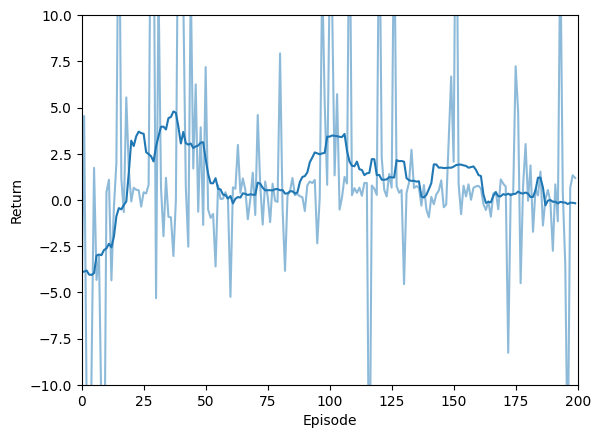

In [123]:
def rolling_average(data, window=10):
    return np.convolve(data, np.ones(window), 'same') / window

episodes = np.arange(len(returns))

fig, ax = plt.subplots()

l1, = ax.plot(returns, alpha=0.5)
ax.plot(episodes, rolling_average(returns, 20), color=l1.get_color())

ax.set_xlim([0, len(returns)])
ax.set_ylim([-10, 10])

ax.set_xlabel('Episode')
ax.set_ylabel('Return')

In [124]:
with torch.no_grad():
    stats_simple = evaluate_agent(agent, episodes=100, verbose=False, n_atoms=5, size=5, edge_width=2)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:05<00:00,  1.54it/s]


In [125]:
import pandas as pd

df = pd.DataFrame({'RandomAgent': stats_random, 'RattleAgent': stats_rattle, 'RelaxAgent': stats_relax, 'TheRønneAgent': stats_simple})
df.drop(labels=['returns'])

RandomAgent RattleAgent RelaxAgent TheRønneAgent
mean_return             -161760.417785   -2.011915    5.06076      1.169366
median_return                -1.041123    0.247757   3.833545      0.483203
std_return              1143472.561431    7.560251   5.483783      4.596825
improvement_percentage            29.0        53.0       99.0          70.0
mean_improvement              3.595023    2.644247    5.15972      2.525214
mean_decay              -227833.042734   -7.262481  -4.736287     -1.994277

So these three agents have quite different levels of performance on this problem. 

I believe this is a rather general environment in it self, but there are options for changes e.g.
- The number of atoms to move can be changed. 
- Rather than moving atoms, they could be added (Though this makes the state description more complicated as its shape changes (?)). 
- The initial configuration could be set in a different way, rather than be random. 
- As discussed the reward function could be changed. 
- Introduce the remaining number of moves as a part of the observation. 

### An agent for the `AtomisticEnvironment`. 

But, now the real question is how do build an algorithm to solve this environment? 
There are a few things we need to keep in mind, related to things we have discussed 
before, but made more complicated by the atomistic nature of the problem. 
One of these is the state and action representations that we will use in the agent. 
The sort of neatest strategy would be to: 
- Selct which atom to move. 
- Directly sample a displacement vector. 

But we will run into problems with the horribly convoluted subject of *equivariance*, that is 
predicting a displacement is not possible without an equivariant representation. Consider e.g. 
the atom centered symmetry functions (ACSF), that as we know are only *invariant*, can 'feel' how close neighbouring atoms are,
but it cannot tell in which direction they are - so it cannot tell the differeence between an atom that is to the left 
or to the right. Thus, predicting a displacement vector based on the ASCFs is bound to fail. 
So probably the best option would be to utilize a equivariant neural network, but that is a 
challenging task so we should try something simpler at first. 



#### Thinking about ASLA

(This next part is a bit involved as it relies on some detailed understanding of the ASLA method, so feeel free 
to ask questions in person to clear things up.)
In ASLA this problem is solved by using a network to predict the state-action value of every action in 
each state and using the $\epsilon$-greedy policy to choose an action. This works because the $Q(s,a)$-value is just 
a scalar so it does not require an equivariant representation to accurately predict - though an 
invariant description is helpful to generalize as the convolutional architecture handles for translational 
and permutational invariance in the first papers and the SchNet-architecture handles for translational, 
permutational and rotational invariance in the latest paper. 

A strategy akin to ASLA would be to 
- Select an atom to move
- Calculate Q-values (DQN-like) or probabilities (policy-gradient like) for all actions on a discretized grid. 
- Select or sample from those. 

The second step would involve descriptors of all the resulting configurations. In ASLA that would be the one-hot grid, 
a section/window of which can be thought of as the state description of the state-action pair of a particular 
grid point. In Sørens SchNet-ASLA the network produces a representation of each grid point that is used to make a prediction. 
A third option would be to actually place the atom being moved in each grid point and make predictions based on a descriptor of 
the resulting configuration. But, the grid is not really a requirement, except for in the convolutional approach, it serves only to 
yield a way to sample the space - for the second two options we can just aswell get our samples in a different manner. 


#### Summary 

The main point of this way too long text is that: Displacements cannot be directly predicted without equivariance, but methods that evaluate the 
probability or value of displacements by looking at the states the displacements results in can circumvent that. 

#### Strategy proposal

This leads us to another strategy: 
- Select an atom to move. 
- Sample a number of configurations with the selected atom displaced in some way (uniformly, randomly, by rattling the atom selected) and use descriptors of these configurations to choose among them. 

So to outline this a bit further, a strategy can be to: 
1. Calculate local descriptors of all atoms $F^a_i$ which can be done using the state observation $s$.
2. Use these to calculate atomic index action preferences $z^a_i(F^a_i)$ with $Z = [z^a_0, .., z^a_N]$
3. Convert these to probabilities using softmax $P^a_i = \mathrm{softmax}(z^a_i, Z^a)$
4. Sample the atomic index $I_a$ using these probabilities. 
5. By some method produce a number of configurations $C = [c_0, .., c_j, .., c_J]$ where atom $I_a$ has been displaced.
6. Use a descriptor as the input to a model (a network most likely) to to predict displacement action prefereences $z^d_j$
7. Convert these to probabilities using a softmax $P^d_j = \mathrm{softmax}(z^d_i, Z^d)$
8. Select a displacement according to these probabilities. 
9. Putting this together the action is $a = (I_a, D)$
9. The final probability of this action is then $P = P^a_{I_a} P^d_{I_d} = \pi(s, a)$
10. Apply REINFORCE using that probability. 

That the action probability is the product of two probability should not matter, so the REINFORCE approach should be perfectly valid and it will drive up both the probability of the selected index and probability of chosen the displacement for combinations of the two that yield a high reward/return. (Caveat: I dont know fully know the effect of the displacement sampling, I guess if it is not uniform in the region of displacements it can sample then there is an untrainable probability that maybe should be taken into account too? But given that it does not depend on the trainable parameters it cannot influence the direction of the policy gradients (? I think).)

A similar scheme can be formulated for a DQN-like approach, basically like the ASLA strategy outlined above as it would require discretization (Even if Q-values can be calculated continously, how do you apply the $\epsilon$-greedy strategy to them? There is actually an answer to that called [DDPG](https://spinningup.openai.com/en/latest/algorithms/ddpg.html)). 

There are many many options, so try the above one outlined above, come up with your own or try with equivariance as outliined in the next notebook. 

### Discretization

For some choices of algorithms you may want to work with a discretized observation representation. 

I have implemented a `gymnasium.ObservationWrapper` that converts the usual `gym.spaces.graph.GraphInstance` observation 
to a discretized grid, much like is used in ASLA. 

The code below shows how that works. 

In [ ]:
from rlweek.atomic_environment.wrappers import DiscretizationWrapper
from rlweek.atomic_environment import (
AtomisticEnvironment,
get_agox_environment,
get_lennard_jones_calculator,
)

# Setup the AGOX environment:
n_atoms = 5
size = 5
edge_width = 2
agox_environment = get_agox_environment(
    symbols=f"H{n_atoms}", size=size, edge_width=edge_width
)

# Calculator:
calc = get_lennard_jones_calculator()

# Setup the gym environment:
grid_size = 10
env = DiscretizationWrapper(AtomisticEnvironment(agox_environment, calc), grid_size=grid_size)

grid0, _ = env.reset()
atoms0 = env.unwrapped.atoms.copy()

# If using this method it is up to your code that produces actions to make sure they correspond to grid points. 
# If you are somehow calculating indices on the grid (e.g. by an argmax operation) they can be converted using 
# env.indices_to_positions(indices).
action = [0, (4.75, 4.75)] # Actions are relative to the confinement cell, so this moves the atom to the upper right corner. 
grid1, reward, _, _, _ = env.step(action)
atoms1 = env.unwrapped.atoms.copy()
print(reward)

# There's also no safety net for actions that bring atoms on top of each other, so keep that in mind. 

In [ ]:
sz = 4
fig, axes = plt.subplots(1, 2, figsize=(2*sz, 1*sz))

extent = (edge_width, size+edge_width, edge_width, size+edge_width)

titles = ['Initial', 'After action']

for ax, grid, atoms, title in zip(axes.flatten(), [grid0, grid1], [atoms0, atoms1], titles):

    ax.imshow(grid[:, :, 0].T, cmap='gray_r', origin='lower', extent=extent)

    ax.scatter(atoms.positions[:, 0], atoms.positions[:, 1], s=100, c='r', marker='o')

    ax.set_title(title)

    ticks = np.linspace(edge_width, size+edge_width, grid_size+1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)

    ax.grid(True)
